# **Air Quality Index (AQI) Analysis in Delhi**

**Import libraries and load data**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load CSV (replace with your file path)
df = pd.read_csv("/content/Delhi_AQI_Dataset1.csv")

In [3]:
# Check structure
print(df.head())
print(df.info())

    City        Date  PM2.5    PM10     NO2     SO2    CO     O3
0  Delhi  01-01-2018  223.3  438.48  336.98  462.84  4.26  385.7
1  Delhi  02-01-2018  229.9  451.44  346.94  476.52  4.39  397.1
2  Delhi  03-01-2018  210.1  412.56  317.06  435.48  4.01  362.9
3  Delhi  04-01-2018  201.3  395.28  303.78  417.24  3.84  347.7
4  Delhi  05-01-2018  214.5  421.20  323.70  444.60  4.10  370.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   City    2191 non-null   object 
 1   Date    2191 non-null   object 
 2   PM2.5   2191 non-null   float64
 3   PM10    2191 non-null   float64
 4   NO2     2191 non-null   float64
 5   SO2     2191 non-null   float64
 6   CO      2191 non-null   float64
 7   O3      2191 non-null   float64
dtypes: float64(6), object(2)
memory usage: 137.1+ KB
None


**Data Cleaning & Preprocessing**

In [4]:
# Check for missing data
print(df.isnull().sum())

City     0
Date     0
PM2.5    0
PM10     0
NO2      0
SO2      0
CO       0
O3       0
dtype: int64


In [5]:
# Check for duplicate data
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Number of duplicate rows: 0


In [6]:
# Standardize column names
# Rename columns to lowercase and snake_case
df = df.rename(columns={
    "Date": "date",
    "AQI": "aqi",
    "PM2.5": "pm2_5",
    "PM10": "pm10",
    "NO2": "no2",
    "SO2": "so2",
    "CO": "co",
    "O3": "o3"
})

In [7]:
#Convert date to datetime
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")

In [8]:
# Remove outliers
# Remove impossible values
for col in ["pm2_5", "pm10", "no2", "so2", "o3"]:
    df.loc[df[col] < 0, col] = np.nan
df.loc[df["co"] < 0, "co"] = np.nan

In [9]:
print(df.describe())

                                date        pm2_5         pm10          no2  \
count                           2191  2191.000000  2191.000000  2191.000000   
mean   2021-05-02 10:01:22.154267392   114.557143   224.948571   172.877143   
min              2018-01-01 00:00:00    22.550000    44.280000    34.030000   
25%              2019-07-02 12:00:00    64.350000   126.360000    97.110000   
50%              2021-01-01 00:00:00   104.500000   205.200000   157.700000   
75%              2023-07-02 12:00:00   158.950000   312.120000   239.870000   
max              2024-12-31 00:00:00   271.700000   533.520000   410.020000   
std                              NaN    58.638060   115.143827    88.490163   

               so2           co           o3  
count  2191.000000  2191.000000  2191.000000  
mean    237.445714     2.187307   197.871429  
min      46.740000     0.430000    38.950000  
25%     133.380000     1.230000   111.150000  
50%     216.600000     2.000000   180.500000  
75%   

**Calculating aqi**

* Calculate sub-indices for each pollutant (PM2.5, PM10, NO2, SO2, CO, O3).

* Take the maximum sub-index as the AQI (we did this).

* Round to the nearest integer (CPCB rounds, not keeps decimals).

* If multiple pollutants share the same highest sub-index, CPCB sometimes applies tie-breaking rules (priority order of pollutants: PM2.5, PM10, NO2, O3, CO, SO2).

In [11]:
# Breakpoint tables for CPCB AQI (India)
breakpoints = {
    "pm2_5": [
        (0, 30, 0, 50),
        (31, 60, 51, 100),
        (61, 90, 101, 200),
        (91, 120, 201, 300),
        (121, 250, 301, 400),
        (251, 500, 401, 500),
    ],
    "pm10": [
        (0, 50, 0, 50),
        (51, 100, 51, 100),
        (101, 250, 101, 200),
        (251, 350, 201, 300),
        (351, 430, 301, 400),
        (431, 1000, 401, 500),
    ],
    "no2": [
        (0, 40, 0, 50),
        (41, 80, 51, 100),
        (81, 180, 101, 200),
        (181, 280, 201, 300),
        (281, 400, 301, 400),
        (401, 1000, 401, 500),
    ],
    "so2": [
        (0, 40, 0, 50),
        (41, 80, 51, 100),
        (81, 380, 101, 200),
        (381, 800, 201, 300),
        (801, 1600, 301, 400),
        (1601, 2000, 401, 500),
    ],
    "co": [
        (0, 1, 0, 50),
        (1.1, 2, 51, 100),
        (2.1, 10, 101, 200),
        (10.1, 17, 201, 300),
        (17.1, 34, 301, 400),
        (34.1, 50, 401, 500),
    ],
    "o3": [
        (0, 50, 0, 50),
        (51, 100, 51, 100),
        (101, 168, 101, 200),
        (169, 208, 201, 300),
        (209, 748, 301, 400),
        (749, 1000, 401, 500),
    ]
}

# Function to calculate sub-index for one pollutant
def calc_sub_index(conc, pollutant):
    for (BP_lo, BP_hi, I_lo, I_hi) in breakpoints[pollutant]:
        if BP_lo <= conc <= BP_hi:
            return ((I_hi - I_lo) / (BP_hi - BP_lo)) * (conc - BP_lo) + I_lo
    return None

# Pollutant priority order (CPCB rule)
priority_order = ["pm2_5", "pm10", "no2", "o3", "co", "so2"]

# Function to calculate AQI row-wise with priority
def calculate_aqi(row):
    sub_indices = {}
    for pollutant in breakpoints.keys():
        val = row[pollutant]
        si = calc_sub_index(val, pollutant)
        if si is not None:
            sub_indices[pollutant] = si

    if not sub_indices:
        return None

    # Find maximum sub-index
    max_val = max(sub_indices.values())

    # Apply priority if tie
    for pollutant in priority_order:
        if pollutant in sub_indices and abs(sub_indices[pollutant] - max_val) < 0.5:
            return int(round(sub_indices[pollutant]))

    return int(round(max_val))
df["aqi"] = df.apply(calculate_aqi, axis=1)

print(df.head())


    City       date  pm2_5    pm10     no2     so2    co     o3  aqi
0  Delhi 2018-01-01  223.3  438.48  336.98  462.84  4.26  385.7  402
1  Delhi 2018-01-02  229.9  451.44  346.94  476.52  4.39  397.1  405
2  Delhi 2018-01-03  210.1  412.56  317.06  435.48  4.01  362.9  378
3  Delhi 2018-01-04  201.3  395.28  303.78  417.24  3.84  347.7  363
4  Delhi 2018-01-05  214.5  421.20  323.70  444.60  4.10  370.5  389


**AQI Categorization**

CPCB defines categories:

* 0–50: Good

* 51–100: Satisfactory

* 101–200: Moderate

* 201–300: Poor

* 301–400: Very Poor

* 401–500: Severe

In [13]:
def categorize_aqi(aqi):
    if pd.isna(aqi): return "NA"
    if aqi <= 50: return "Good"
    elif aqi <= 100: return "Satisfactory"
    elif aqi <= 200: return "Moderate"
    elif aqi <= 300: return "Poor"
    elif aqi <= 400: return "Very Poor"
    else: return "Severe"

df["aqi_category"] = df["aqi"].apply(categorize_aqi)
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year
df["day"] = df["date"].dt.day

**Exploratory Data Analysis (EDA)**

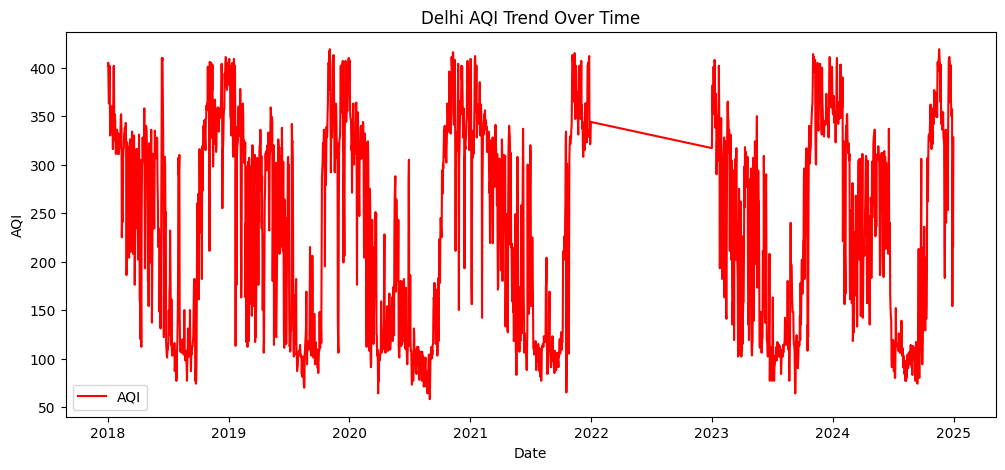

In [14]:
# AQI Trend over Time
plt.figure(figsize=(12,5))
plt.plot(df["date"], df["aqi"], label="AQI", color="red")
plt.title("Delhi AQI Trend Over Time")
plt.xlabel("Date")
plt.ylabel("AQI")
plt.legend()
plt.show()

The graph shows the Air Quality Index (AQI) trend in Delhi over time. We can observe significant fluctuations in the AQI, with distinct seasonal patterns. The AQI tends to be higher (indicating poorer air quality) during certain periods of the year, likely corresponding to specific seasons or events.

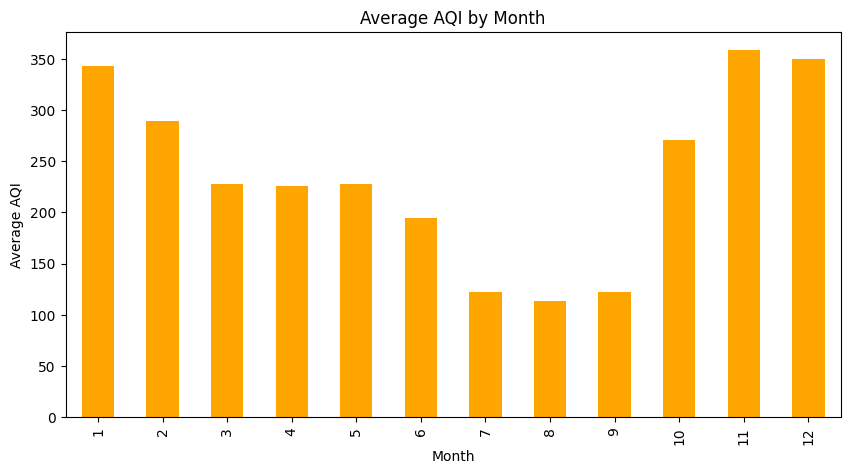

In [15]:
# Seasonality (Monthly AQI)
monthly = df.groupby(df["date"].dt.month)["aqi"].mean()
monthly.plot(kind="bar", figsize=(10,5), color="orange")
plt.title("Average AQI by Month")
plt.xlabel("Month")
plt.ylabel("Average AQI")
plt.show()

This bar chart illustrates the average Air Quality Index (AQI) for each month in Delhi. It clearly shows a seasonal pattern, with significantly higher average AQI values during the winter months (November, December, and January) compared to the summer months (June, July, and August). This indicates that air quality is generally worse in Delhi during the winter.

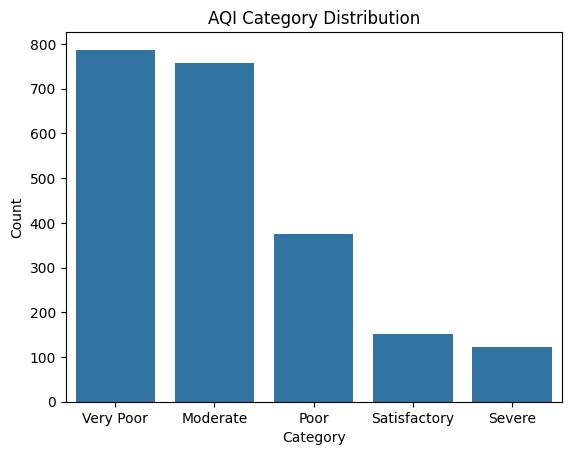

In [16]:
# AQI Category Distribution
sns.countplot(data=df, x="aqi_category", order=df["aqi_category"].value_counts().index)
plt.title("AQI Category Distribution")
plt.xlabel("Category")
plt.ylabel("Count")
plt.show()

This bar chart shows the distribution of Air Quality Index (AQI) categories in Delhi. Each bar represents an AQI category (Good, Satisfactory, Moderate, Poor, Very Poor, and Severe), and the height of the bar indicates the number of days that fell into that category. This plot helps us understand the overall air quality situation in Delhi by showing how frequently different levels of air pollution occur.

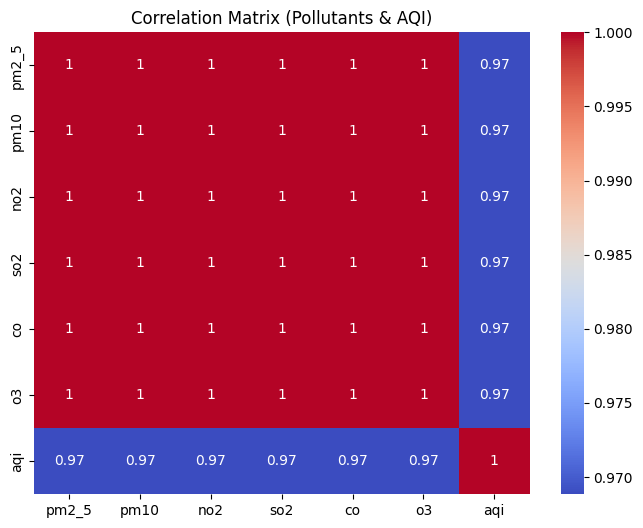

In [17]:
# Pollutant Correlations
corr = df[["pm2_5","pm10","no2","so2","co","o3","aqi"]].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Pollutants & AQI)")
plt.show()

This heatmap shows the correlation matrix between the different pollutants and the calculated AQI.

You'll notice very high correlation values (close to 1) between all the pollutants and also between each pollutant and the AQI. While some correlation is expected as these pollutants contribute to air quality, such extremely high correlations might suggest a few things:

*   **Multicollinearity:** The pollutant levels are highly correlated with each other. This is important to consider if you were to build a linear regression model, as it can affect the interpretation of individual pollutant effects.
*   **AQI Calculation Method:** The way the AQI is calculated (taking the maximum of the sub-indices of different pollutants) inherently leads to a high correlation between the individual pollutants and the final AQI, as the highest sub-index largely determines the AQI value.

In this specific case, the high correlations are likely a combination of both the natural relationships between pollutants in the atmosphere and the method used to calculate the AQI.

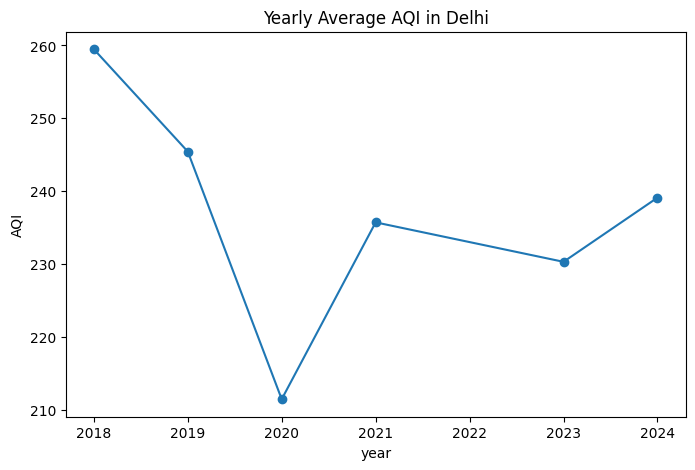

In [20]:
# Seasonal & Yearly Analysis
# Yearly mean AQI
yearly = df.groupby("year")["aqi"].mean()
yearly.plot(marker="o", figsize=(8,5))
plt.title("Yearly Average AQI in Delhi")
plt.ylabel("AQI")
plt.show()

This line chart shows the yearly average Air Quality Index (AQI) in Delhi. We can observe fluctuations in the yearly average AQI, with a notable dip in 2020, likely influenced by factors such as the COVID-19 lockdown. The trend after 2020 shows some variation, indicating that air quality levels can vary significantly from year to year.

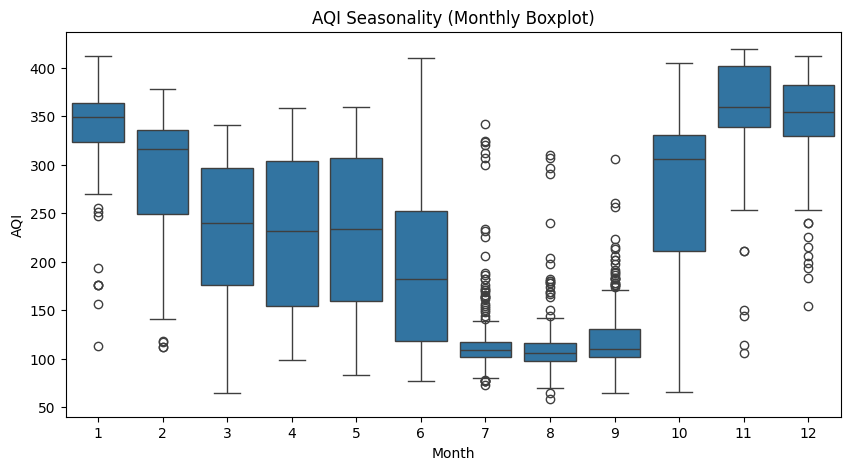

In [19]:
# Boxplot for AQI per month
plt.figure(figsize=(10,5))
sns.boxplot(x="month", y="aqi", data=df)
plt.title("AQI Seasonality (Monthly Boxplot)")
plt.xlabel("Month")
plt.ylabel("AQI")
plt.show()

This boxplot provides a more in-depth look at the seasonal variations in Delhi's AQI. We can see that the median AQI values are significantly higher during the winter months (e.g., November, December, January) compared to the summer months (e.g., June, July, August). The boxes are also generally larger in the winter months, indicating a wider range of AQI values and more variability. This reinforces the observation from the monthly average bar chart that air quality is poorest in the winter, but the boxplot also shows the spread and presence of outliers (very high AQI days) in each month.

Pollutants most correlated with AQI:
 co       0.968848
so2      0.968834
o3       0.968834
pm10     0.968834
pm2_5    0.968834
no2      0.968834
Name: aqi, dtype: float64


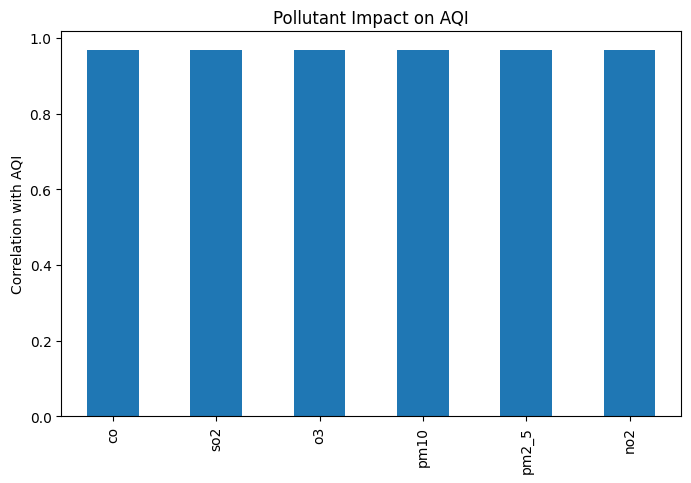

In [21]:
# Pollutant Contribution Analysis
corr_with_aqi = corr["aqi"].drop("aqi").sort_values(ascending=False)
print("Pollutants most correlated with AQI:\n", corr_with_aqi)

corr_with_aqi.plot(kind="bar", figsize=(8,5))
plt.title("Pollutant Impact on AQI")
plt.ylabel("Correlation with AQI")
plt.show()

This bar chart shows the correlation of each pollutant with the calculated AQI. As seen in the correlation heatmap, all pollutants have a very high positive correlation with the AQI (close to 1). This is expected because the AQI is calculated based on the concentrations of these pollutants. The high correlation indicates that as the concentration of any of these pollutants increases, the AQI is likely to increase as well, reflecting poorer air quality. While all pollutants are highly correlated with the AQI, the slight variations in correlation values might indicate a very minor difference in their individual impact on the overall AQI calculation, although the differences are minimal in this case.

aqi_category
Very Poor       787
Moderate        757
Poor            374
Satisfactory    151
Severe          122
Name: count, dtype: int64


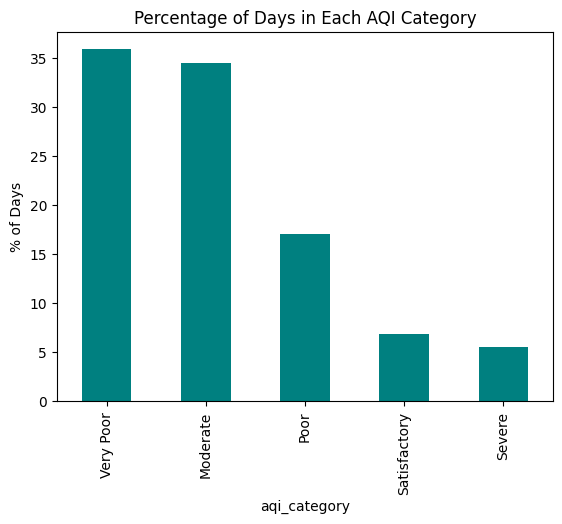

In [22]:
# Count days in each AQI category
category_counts = df["aqi_category"].value_counts()
print(category_counts)

(category_counts / len(df) * 100).plot(kind="bar", color="teal")
plt.title("Percentage of Days in Each AQI Category")
plt.ylabel("% of Days")
plt.show()


This bar chart shows the percentage of days falling into each Air Quality Index (AQI) category in Delhi. It provides a clear picture of the overall air quality profile by indicating how frequently the air quality is "Good," "Satisfactory," "Moderate," "Poor," "Very Poor," or "Severe." Observing the heights of the bars, you can quickly see which AQI categories are most common and understand the general severity of air pollution in Delhi over the analyzed period.